## checking things

In [ ]:
!nvidia-smi

Thu Jun  6 10:27:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   41C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
conda env list

# conda environments:
#
myenv                    /home/ai4054/.conda/envs/myenv
pim-env               *  /home/ai4054/.conda/envs/pim-env
base                     /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0
netcdf-py39              /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/netcdf-py39
pytorch-2.2.2            /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/pytorch-2.2.2
tensorflow-2.12.1        /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/tensorflow-2.12.1


Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda list

# packages in environment at /home/ai4054/.conda/envs/pim-env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alembic                   1.13.1                   pypi_0    pypi
anyio                     4.3.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hd1e30aa_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge

In [ ]:
import sys
print(sys.executable)

/home/ai4054/.conda/envs/pim-env/bin/python


In [ ]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

pim-env


In [ ]:
import xgboost
import catboost
import imblearn
import lightgbm

# Load data

In [1]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Download dataset
!kaggle competitions download -c forest-type-classification-spai

100% 463k/463k [00:00<00:00, 594kB/s]
100% 463k/463k [00:00<00:00, 594kB/s]


In [3]:
!unzip /content/forest-type-classification-spai.zip && rm -rf /content/forest-type-classification-spai.zip

Archive:  /content/forest-type-classification-spai.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import and Visualize data

In [1]:
import os
def create_folders_if_not_exist(*paths):
    for path in paths:
        os.makedirs(path, exist_ok=True)
        print(f"Ensured directory exists: {path}")

# PATH to dataset and to Save the results
data_path = 'dataset'
results_path = 'results/multmodels_optuna/features_select-RFECV'
create_folders_if_not_exist(data_path, results_path)

Ensured directory exists: dataset
Ensured directory exists: results/multmodels_optuna/features_select-RFECV


In [2]:
# data_path = '/content/'
# results_path = '/content/' + results_path

In [13]:
import pandas as pd

# Load the training CSV file to check its contents and structure
train_file_path = f'{data_path}/train.csv'
train_df = pd.read_csv(train_file_path)
test_file_path = f'{data_path}/test.csv'
test_df = pd.read_csv(test_file_path)

# Display the first few rows of the training dataframe
train_df.head()

id   b1   b11   b12   b2    b3   b4    b5    b6    b7    b8  b8_a    b9  \
0   2002  293  1927  1038  278   475  453   987  1773  2184  1900  2343  3039   
1   3212  197  1598   697  201   347  228   682  1982  2449  2254  2685  2690   
2  13312  929  1975  1031  982  1020  856  1220  2051  2421  2392  2671  2683   
3  17020  132  1560   689  189   408  175   609  2117  2907  3024  3005  2955   
4   5967  241  1944  1131  362   538  487   918  1549  1844  1702  2077  2043   

  nforest_type  
0          MDF  
1          DDF  
2          MDF  
3          MDF  
4          MDF

In [35]:
# List of band columns
bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'b9', 'b11', 'b12']

train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Normalize the bands
for band in bands:
    max_valu_train = train_df[band].max()
    max_valu_test = test_df[band].max()

    if max_valu_train != 0:  # Check to prevent division by zero
        train_df_norm[band] = train_df[band] / max_valu_train
    else:
        print(f"Warning: Maximum value for train -{band} is zero. Skipping normalization for this band.")

    if max_valu_test != 0:  # Check to prevent division by zero
        test_df_norm[band] = test_df[band] / max_valu_test
    else:
        print(f"Warning: Maximum value for test - {band} is zero. Skipping normalization for this band.")

# Verify the normalization
print(train_df_norm[bands].describe())

                 b1            b2            b3            b4            b5  \
count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
mean       0.134858      0.161371      0.216965      0.176727      0.288734   
std        0.115918      0.125425      0.108889      0.117288      0.097244   
min        0.000000      0.000403      0.036732      0.021166      0.044444   
25%        0.069190      0.088710      0.148426      0.098642      0.218357   
50%        0.093272      0.114919      0.182909      0.137780      0.263768   
75%        0.153670      0.182661      0.256372      0.219249      0.343961   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 b6            b7            b8          b8_a            b9  \
count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
mean       0.516985      0.508525      0.533214      0.557667      0.337516   
std        0.091326      0.091718      0.102617    

In [36]:
train_df_norm

id        b1       b11       b12        b2        b3        b4  \
0       2002  0.112003  0.468856  0.207849  0.112097  0.178036  0.180911   
1       3212  0.075306  0.388808  0.139567  0.081048  0.130060  0.091054   
2      13312  0.355122  0.480535  0.206448  0.395968  0.382309  0.341853   
3      17020  0.050459  0.379562  0.137966  0.076210  0.152924  0.069888   
4       5967  0.092125  0.472993  0.226472  0.145968  0.201649  0.194489   
...      ...       ...       ...       ...       ...       ...       ...   
13048   9185  0.142966  0.472019  0.211053  0.154032  0.211769  0.198882   
13049  13977  0.758028  0.876399  0.544654  0.654032  0.667916  0.705272   
13050    755  0.359327  0.488321  0.229876  0.393145  0.404798  0.386581   
13051   1616  0.448777  0.562530  0.238286  0.448387  0.422039  0.355032   
13052  15634  0.073777  0.508759  0.217060  0.110484  0.188156  0.180511   

             b5        b6        b7        b8      b8_a        b9 nforest_type  
0      0.317874  0.445701  0.442105  0.391914  0.466083  0.364870          MDF  
1      0.219646  0.498240  0.495749  0.464934  0.534116  0.322968          DDF  
2      0.392915  0.515586  0.490081  0.493399  0.531331  0.322128          MDF  
3      0.196135  0.532177  0.588462  0.623762  0.597772  0.354784          MDF  
4      0.295652  0.389392  0.373279  0.351073  0.413169  0.245288          MDF  
...         ...       ...       ...       ...       ...       ...          ...  
13048  0.314654  0.421820  0.390486  0.435025  0.455739  0.252131          DDF  
13049  0.745250  0.876823  0.789474  0.809406  0.814999  0.726738          DDF  
13050  0.403221  0.447461  0.401417  0.400578  0.446986  0.260535          DDF  
13051  0.421900  0.631222  0.624494  0.629125  0.675552  0.405811          MDF  
13052  0.283736  0.490950  0.491296  0.583746  0.569525  0.310481          MDF  

[13053 rows x 14 columns]

## Data Preprocess

In [37]:
# Encode labels to numbers
from sklearn.preprocessing import LabelEncoder

# Fit the label encoder on the original labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df_norm['nforest_type'])

# Print the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original to Encoded):", label_mapping)
y_encoded

Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}


array([2, 0, 2, ..., 0, 2, 2])

In [38]:
import numpy as np
# Compute all indices (80)
def compute_all_indices(df):
    df['NDVI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'])
    df['Adjusted_transformed_soil_adjusted_VI'] = 1.22 * ((df['b8'] - 1.22 * df['b4'] - 0.03) / (1.22 * df['b8'] + df['b4'] - 1.22 * 0.03 + 0.08 * (1 + (1.22 * 1.22))))
    df['Aerosol_free_vegetation_index_1600'] = (df['b8'] - 0.66 * (df['b11'] / (df['b8'] + 0.66 * df['b11'])))
    df['Aerosol_free_vegetation_index_2100'] = (df['b8'] - 0.5 * (df['b12'] / (df['b8'] + 0.56 * df['b12'])))
    df['Alteration'] = df['b11'] / df['b12']
    df['Anthocyanin_reflectance_index'] = (1 / df['b3']) - (1 / df['b5'])
    df['Atmospherically_Resistant_Vegetation_Index_2'] = -0.18 + 1.17 * ((df['b8'] - df['b4']) / (df['b8'] + df['b4']))
    df['Blue_wide_dynamic_range_vegetation_index'] = (0.1 * df['b8'] - df['b2']) / (0.1 * df['b8'] + df['b2'])
    df['Browning_Reflectance_Index'] = df['Anthocyanin_reflectance_index'] / df['b8']
    df['Chlorophyll_Absorption_Ratio_Index'] = (df['b5'] / df['b4']) * np.sqrt(670 / 150 * (df['b5'] - df['b3']) + df['b4'] + (df['b3'] - (550 / 150 * (df['b5'] - df['b3']))) ** 2) / np.sqrt((1 + (df['b5'] - df['b3']) / (150 * 150)))
    df['Chlorophyll_Green'] = df['b3'] / df['b7']
    df['Chlorophyll_Index_Green'] = (df['b8'] / df['b3']) - 1
    df['Chlorophyll_IndexRedEdge'] = (df['b8'] / df['b5']) - 1
    df['Chlorophyll_Red_Edge'] = df['b5'] / df['b7']
    df['Chlorophyll_vegetation_index'] = df['b8'] * df['b5'] / (df['b3'] ** 2)
    df['Coloration_Index'] = (df['b4'] - df['b2']) / df['b4']
    df['CRI550'] = (1 / df['b2']) - (1 / df['b3'])
    df['CRI700'] = (1 / df['b2']) - (1 / df['b5'])
    df['Datt1'] = (df['b8'] - df['b5']) / (df['b8'] - df['b4'])
    df['Datt4'] = (df['b4']) / (df['b3'] * df['b5'])
    df['Datt6'] = (df['b8_a']) / (df['b3'] * df['b5'])
    df['Difference_678_500'] = df['b4'] - df['b2']
    df['Difference_800_550'] = df['b8'] - df['b3']
    df['Difference_800_680'] = df['b8'] - df['b4']
    df['EVI'] = 2.5 * (df['b8'] - df['b4']) / (df['b8'] + 6 * df['b4'] - 7.5 * df['b2'] + 1)
    df['EVI2'] = 2.5 * (df['b8'] - df['b4']) / (df['b8'] + 2.4 * df['b4'] + 1)
    df['Ferrous_Silicates'] = df['b12'] - df['b11']
    df['Global_Environment_Monitoring_Index'] = ((((2 * (df['b8'] - df['b4']) * (df['b8'] + df['b4'])) + (1.5 * df['b8']) + (0.5 * df['b4'])) / (df['b8'] + df['b4'] + 0.5)) * (1 - (0.25 * (((2 * (df['b8'] - df['b4']) * (df['b8'] + df['b4'])) + (1.5 * df['b8']) + (0.5 * df['b4'])) / (df['b8'] + df['b4'] + 0.5))))) - ((df['b4'] - 0.125) / (1 - df['b5']))
    df['Gossan'] = df['b11'] / df['b4']
    df['Green_atmospherically_resistant_vegetation_index'] = (df['b8'] - (df['b3'] + df['b4'])) / (df['b8'] + (df['b3'] + df['b4']))
    df['Green_leaf_index'] = (2 * df['b3'] - df['b4'] - df['b2']) / (2 * df['b3'] + df['b4'] + df['b2'])
    df['Green_Normalized_Difference_Vegetation_Index'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'])
    df['Green_Soil_Adjusted_Vegetation_Index'] = (df['b8'] - df['b3']) * (1 + 5) / (df['b8'] + df['b3'] + 5)
    df['Green_Blue_NDVI'] = (df['b8'] - (df['b3'] + df['b2'])) / (df['b8'] + (df['b3'] + df['b2']))
    df['Green_Red_NDVI'] = (df['b8'] - (df['b3'] + df['b4'])) / (df['b8'] + (df['b3'] + df['b4']))
    df['Hue'] = np.arctan((2 * df['b4'] - df['b3'] - df['b2']) * (df['b3'] - df['b2']) / 30.5)
    df['Infrared_percentage_vegetation_index'] = ((df['b8'] / (df['b8'] + df['b4'])) / 2) * (df['NDVI'] + 1)
    df['Intensity'] = 1 / 30.5 * (df['b2'] + df['b3'] + df['b4'])
    df['Inverse_reflectance_550'] = 1 / df['b3']
    df['Inverse_reflectance_700'] = 1 / df['b5']
    df['Leaf_Chlorophyll_Index'] = (df['b8'] - df['b5']) / (df['b8'] + df['b4'])
    df['Log_Ratio'] = np.log(df['b8'] / df['b4'])
    df['Maccioni'] = (df['b7'] - df['b5']) / (df['b7'] - df['b4'])
    df['MCARI_MTVI2'] = (df['b5'] / df['b4']) * ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b4'])) / (1.5 * (1.2 * (df['b8'] - df['b3']) - 2.5 * (df['b4'] - df['b3'])) / np.sqrt((2 * df['b8'] + 1) ** 2 - ((df['b6'] * df['b8']) - (5 * np.sqrt(df['b4']))) - 0.5))
    df['MCARI_OSAVI'] = (df['b5'] / df['b4']) * ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b4'])) / ((1 + 0.16) * (df['b8'] - df['b4']) / (df['b8'] + df['b4'] + 0.16))
    df['mCRIG'] = ((1 / df['b2']) - (1 / df['b3'])) * df['b8']
    df['mCRIRE'] = ((1 / df['b2']) - (1 / df['b5'])) * df['b8']
    df['mND680'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4'] - 2 * df['b1'])
    df['Modified_anthocyanin_reflectance_index'] = ((1 / df['b3']) - (1 / df['b5'])) * df['b8']
    df['Modified_Chlorophyll_Absorption_in_Reflectance_Index'] = ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b3'])) * (df['b5'] / df['b4'])
    df['Modified_Chlorophyll_Absorption_in_Reflectance_Index1'] = (2.5 * (df['b8'] - df['b4']) - 1.3 * (df['b8'] - df['b3'])) * (1.2)
    df['Modified_Chlorophyll_Absorption_in_Reflectance_Index2'] = 1.5 * df['Modified_Chlorophyll_Absorption_in_Reflectance_Index1'] / np.sqrt((2 * df['b8'] + 1) ** 2 - ((df['b6'] * df['b8']) - (5 * np.sqrt(df['b4']))) - 0.5)
    df['Modified_Simple_Ratio_670_800'] = ((df['b8'] / df['b4']) - 1) / np.sqrt(((df['b8'] / df['b4']) + 1))
    df['Modified_Soil_Adjusted_Vegetation_Index'] = (2 * df['b8'] + 1 - np.sqrt((2 * df['b8'] + 1) ** 2 + 8 * (df['b8'] - df['b4']))) / 2
    df['Modified_Triangular_Vegetation_Index_1'] = 1.2 * (1.2 * (df['b8'] - df['b3']) - 2.5 * (df['b4'] - df['b3']))
    df['Modified_Triangular_Vegetation_Index_2'] = 1.5 * df['Modified_Triangular_Vegetation_Index_1'] / np.sqrt((2 * df['b8'] + 1) ** 2 - ((df['b6'] * df['b8']) - (5 * np.sqrt(df['b4']))) - 0.5)
    df['Norm G'] = df['b3']/(df['b8']+df['b4']+df['b3'])
    df['Norm NIR'] = df['b8']/(df['b8']+df['b4']+df['b3'])
    df['Norm R'] = df['b4']/(df['b8']+df['b4']+df['b3'])
    df['Normalized Difference 550/450'] = (df['b3'] - df['b1']) / (df['b3'] + df['b1'])
    df['Normalized Difference 550/650'] = (df['b3'] - df['b4']) / (df['b3'] + df['b4'])
    df['Normalized Difference 774/677'] = (df['b7'] - df['b4']) / (df['b7'] + df['b4'])
    df['Normalized Difference 780/550'] = (df['b7'] - df['b3']) / (df['b7'] + df['b3'])
    df['Normalized Difference 800/2170'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
    df['Normalized Difference 800/470'] = (df['b8'] - df['b2']) / (df['b8'] + df['b2'])
    df['Normalized Difference 860/1640'] = (df['b8_a'] - df['b11']) / (df['b8_a'] + df['b11'])
    df['Normalized Difference NIR/Rededge'] = (df['b9'] - df['b5']) / (df['b9'] + df['b5'])
    df['Normalized Difference Red/Green'] = (df['b3'] - df['b5']) / (df['b3'] + df['b5'])
    df['Normalized Difference Salinity Index'] = (df['b11'] - df['b12']) / (df['b11'] + df['b12'])
    df['Optimized Soil Adjusted Vegetation Index'] = (1+0.16)*(df['b8']-df['b4'])/(df['b8']+df['b4']+0.16)
    df['Pan NDVI'] = (df['b8']-(df['b4']+df['b3']+df['b2']))/(df['b8']+(df['b4']+df['b3']+df['b2']))
    df['RDVI'] = (df['b8'] - df['b4']) / np.sqrt(df['b8'] + df['b4'])
    df['Red edge 1'] = df['b5']-df['b4']
    df['Red-Blue NDVI'] = (df['b8']-(df['b4']+df['b2']))/(df['b8']+(df['b4']+df['b2']))
    df['Red-Edge Inflection Point 1'] = 700+40*((((df['b4']+df['b7'])/2)-5)/(df['b6']-df['b5']))
    df['Red-Edge Inflection Point 2'] = 702+40*((((df['b4']+df['b7'])/2)-5)/(df['b6']-df['b5']))
    df['Red-Edge Inflection Point 3'] = 705+35*((((df['b4']+df['b7'])/2)-5)/(df['b6']-df['b5']))
    df['Reflectance at the inflexion point'] =  (df['b4']+df['b7'])/2
    return df


train_df_new = compute_all_indices(train_df_norm)
test_df_new = compute_all_indices(test_df_norm)
train_df_new.head()

id        b1       b11       b12        b2        b3        b4  \
0   2002  0.112003  0.468856  0.207849  0.112097  0.178036  0.180911   
1   3212  0.075306  0.388808  0.139567  0.081048  0.130060  0.091054   
2  13312  0.355122  0.480535  0.206448  0.395968  0.382309  0.341853   
3  17020  0.050459  0.379562  0.137966  0.076210  0.152924  0.069888   
4   5967  0.092125  0.472993  0.226472  0.145968  0.201649  0.194489   

         b5        b6        b7  ...  Normalized Difference Salinity Index  \
0  0.317874  0.445701  0.442105  ...                              0.385702   
1  0.219646  0.498240  0.495749  ...                              0.471711   
2  0.392915  0.515586  0.490081  ...                              0.398973   
3  0.196135  0.532177  0.588462  ...                              0.466828   
4  0.295652  0.389392  0.373279  ...                              0.352442   

   Optimized Soil Adjusted Vegetation Index  Pan NDVI      RDVI  Red edge 1  \
0                                  0.334001 -0.091695  0.278791    0.136964   
1                                  0.605737  0.212191  0.501417    0.128591   
2                                  0.176632 -0.388422  0.165820    0.051062   
3                                  0.752643  0.351914  0.665029    0.126247   
4                                  0.257436 -0.213880  0.211995    0.101163   

   Red-Blue NDVI  Red-Edge Inflection Point 1  Red-Edge Inflection Point 2  \
0       0.144406                  -767.137151                  -765.137151   
1       0.459677                    24.236933                    26.236933   
2      -0.198520                  -794.739740                  -792.739740   
3       0.620456                   144.018402                   146.018402   
4       0.015352                 -1312.435275                 -1310.435275   

   Red-Edge Inflection Point 3  Reflectance at the inflexion point  
0                  -578.745007                            0.311508  
1                   113.707316                            0.293402  
2                  -602.897273                            0.415967  
3                   218.516102                            0.329175  
4                 -1055.880866                            0.283884  

[5 rows x 92 columns]

In [39]:
train_df_new['nforest_type']

0        MDF
1        DDF
2        MDF
3        MDF
4        MDF
        ... 
13048    DDF
13049    DDF
13050    DDF
13051    MDF
13052    MDF
Name: nforest_type, Length: 13053, dtype: object

In [40]:
train_df_new.to_csv(f'{results_path}/pim_prepdata_feat04_train.csv', index=False)
test_df_new.to_csv(f'{results_path}/pim_prepdata_feat04_test.csv', index=False)

--------------------------------------------
## Adjust feature types before using them in models

In [41]:
#Identify Non-Numeric Columns (should be the labels one ('nforest_type'), we change labels-->numbers)

# Find columns with non-numeric values in train data
non_numeric_columns_train = train_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in train data:", non_numeric_columns_train)

# Find columns with non-numeric values in test data
non_numeric_columns_test = test_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in test data:", non_numeric_columns_test)

Non-numeric columns in train data: Index(['nforest_type'], dtype='object')
Non-numeric columns in test data: Index([], dtype='object')


In [42]:
#Handle Non-Numeric Values
from sklearn.preprocessing import LabelEncoder
train_df_new_num = train_df_new.copy()
test_df_new_num = test_df_new.copy()

# Encode non-numeric values in train data
label_encoders = {}
for col in non_numeric_columns_train:
    le = LabelEncoder()
    train_df_new_num[col] = le.fit_transform(train_df_new_num[col].astype(str))
    label_encoders[col] = le

# Encode non-numeric values in test data using the same encoders
for col in non_numeric_columns_test:
    le = label_encoders.get(col, LabelEncoder())
    test_df_new_num[col] = le.transform(test_df_new_num[col].astype(str)) if col in label_encoders else le.fit_transform(test_df_new_num[col].astype(str))

# Verify the encoding
print(train_df_new_num.head())
print(test_df_new_num.head())

      id        b1       b11       b12        b2        b3        b4  \
0   2002  0.112003  0.468856  0.207849  0.112097  0.178036  0.180911   
1   3212  0.075306  0.388808  0.139567  0.081048  0.130060  0.091054   
2  13312  0.355122  0.480535  0.206448  0.395968  0.382309  0.341853   
3  17020  0.050459  0.379562  0.137966  0.076210  0.152924  0.069888   
4   5967  0.092125  0.472993  0.226472  0.145968  0.201649  0.194489   

         b5        b6        b7  ...  Normalized Difference Salinity Index  \
0  0.317874  0.445701  0.442105  ...                              0.385702   
1  0.219646  0.498240  0.495749  ...                              0.471711   
2  0.392915  0.515586  0.490081  ...                              0.398973   
3  0.196135  0.532177  0.588462  ...                              0.466828   
4  0.295652  0.389392  0.373279  ...                              0.352442   

   Optimized Soil Adjusted Vegetation Index  Pan NDVI      RDVI  Red edge 1  \
0                  

In [43]:
train_df_new_num['nforest_type']

0        2
1        0
2        2
3        2
4        2
        ..
13048    0
13049    0
13050    0
13051    2
13052    2
Name: nforest_type, Length: 13053, dtype: int64

------

/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


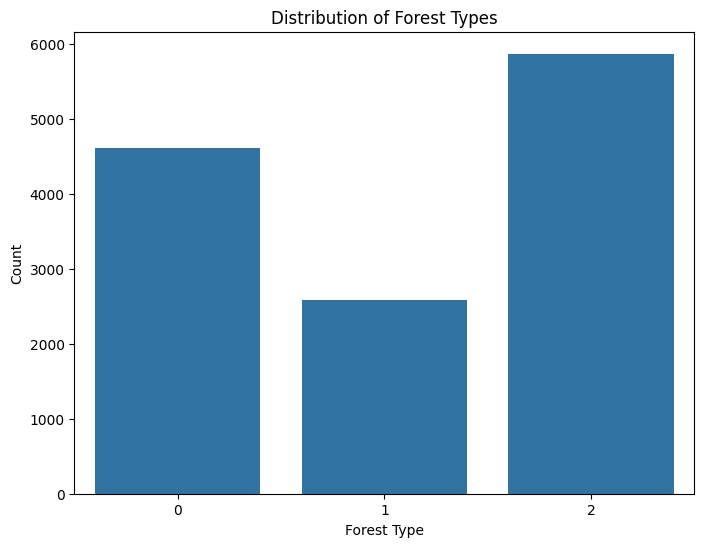

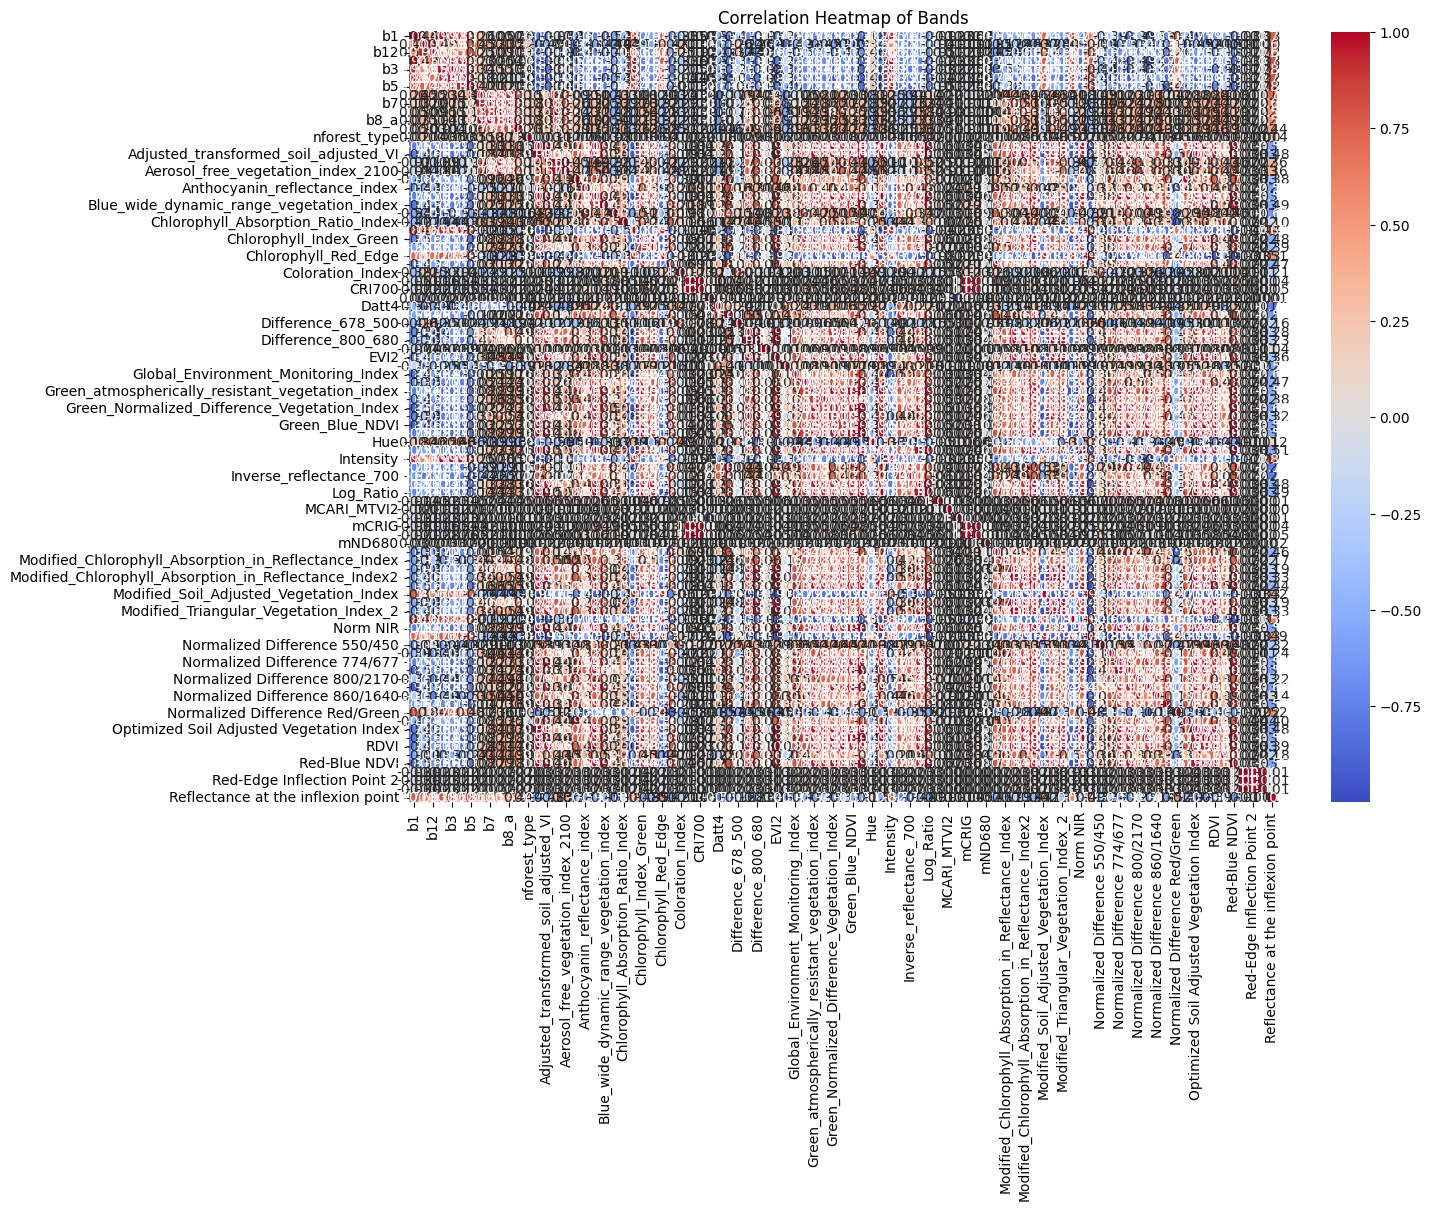

(                 id            b1           b11           b12            b2  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean    8546.088179      0.134858      0.434483      0.179124      0.161371   
 std     4918.719492      0.115918      0.081769      0.053731      0.125425   
 min        0.000000      0.000000      0.040633      0.013016      0.000403   
 25%     4280.000000      0.069190      0.372263      0.139567      0.088710   
 50%     8540.000000      0.093272      0.431630      0.170805      0.114919   
 75%    12798.000000      0.153670      0.489538      0.209451      0.182661   
 max    17051.000000      1.000000      1.000000      1.000000      1.000000   
 
                  b3            b4            b5            b6            b7  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean       0.216965      0.176727      0.288734      0.516985      0.508525   
 std        0.108889      0.117288    

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary_stats = train_df_new_num.describe()

# Distribution of forest types
forest_type_distribution = train_df_new_num['nforest_type'].value_counts()

# Correlation analysis
correlation_matrix = train_df_new_num.drop(columns=['id']).corr()

# Plotting the distribution of forest types
plt.figure(figsize=(8, 6))
sns.barplot(x=forest_type_distribution.index, y=forest_type_distribution.values)
plt.title('Distribution of Forest Types')
plt.xlabel('Forest Type')
plt.ylabel('Count')
plt.show()

# Plotting the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Bands')
plt.show()

summary_stats, forest_type_distribution

******************
------------------------------------
## Feature selection (RFECV)

Checking for infinity values:
id                                    0
b1                                    0
b11                                   0
b12                                   0
b2                                    0
                                     ..
Red-Blue NDVI                         0
Red-Edge Inflection Point 1           1
Red-Edge Inflection Point 2           1
Red-Edge Inflection Point 3           1
Reflectance at the inflexion point    0
Length: 92, dtype: int64
Checking for NaN values:
id                                    0
b1                                    0
b11                                   0
b12                                   0
b2                                    0
                                     ..
Red-Blue NDVI                         0
Red-Edge Inflection Point 1           0
Red-Edge Inflection Point 2           0
Red-Edge Inflection Point 3           0
Reflectance at the inflexion point    0
Length: 92, dtype: int64


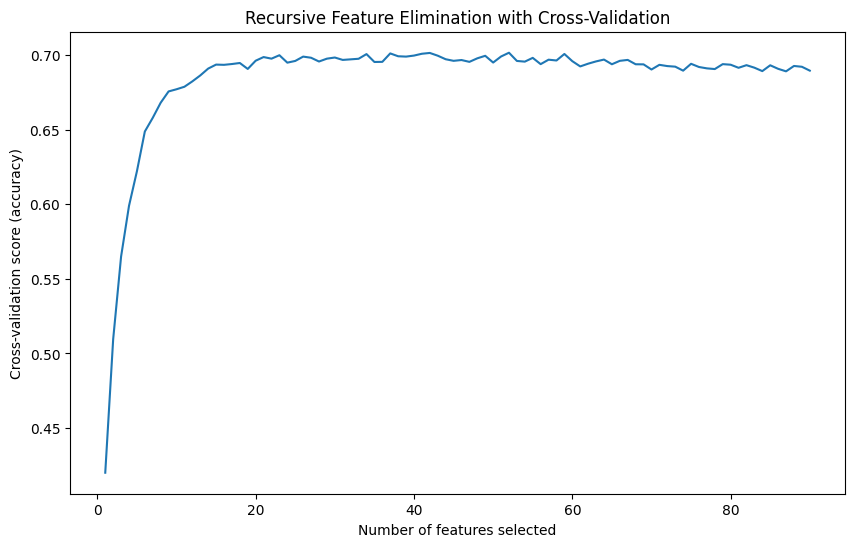

['b1', 'b11', 'b12', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'b9', 'Aerosol_free_vegetation_index_1600', 'Aerosol_free_vegetation_index_2100', 'Alteration', 'Browning_Reflectance_Index', 'Chlorophyll_Absorption_Ratio_Index', 'Chlorophyll_Green', 'Chlorophyll_Red_Edge', 'Coloration_Index', 'CRI550', 'Datt1', 'Datt4', 'Datt6', 'Difference_678_500', 'EVI', 'Ferrous_Silicates', 'Gossan', 'Green_leaf_index', 'Green_Soil_Adjusted_Vegetation_Index', 'Hue', 'Inverse_reflectance_700', 'Leaf_Chlorophyll_Index', 'Maccioni', 'MCARI_MTVI2', 'MCARI_OSAVI', 'mCRIG', 'mCRIRE', 'mND680', 'Modified_Chlorophyll_Absorption_in_Reflectance_Index', 'Modified_Triangular_Vegetation_Index_1', 'Norm G', 'Normalized Difference 550/450', 'Normalized Difference 550/650', 'Normalized Difference 780/550', 'Normalized Difference 800/2170', 'Normalized Difference 860/1640', 'Normalized Difference NIR/Rededge', 'Normalized Difference Red/Green', 'Normalized Difference Salinity Index', 'Red edge 1', 'Red-Edge Inflection Point 1'

In [45]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

normalized_train_data = train_df_new_num.copy()

# Check for any infinity or NaN values
print("Checking for infinity values:")
print(np.isinf(normalized_train_data).sum())
print("Checking for NaN values:")
print(normalized_train_data.isna().sum())

# Replace infinity values with NaN and drop them
normalized_train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
normalized_train_data.dropna(inplace=True)

# Prepare the data for RFECV
X_for_select = normalized_train_data.drop(['id', 'nforest_type'], axis=1)
y_for_select = normalized_train_data['nforest_type']

# Define the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the RFECV
rfecv = RFECV(estimator=classifier, step=1, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the RFECV to the data
rfecv.fit(X_for_select, y_for_select)

# Get the selected features
selected_features_rfecv = X_for_select.columns[rfecv.support_].tolist()

# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("Recursive Feature Elimination with Cross-Validation")
plt.show()

# Print the selected features
print(selected_features_rfecv)


In [47]:
# Extend the selected_features list to include 'id' and 'nforest_type'
train_selected_features = selected_features_rfecv + ['id', 'nforest_type']
test_selected_features = selected_features_rfecv + ['id']
train_selected_features

['b1',
 'b11',
 'b12',
 'b5',
 'b6',
 'b7',
 'b8',
 'b8_a',
 'b9',
 'Aerosol_free_vegetation_index_1600',
 'Aerosol_free_vegetation_index_2100',
 'Alteration',
 'Browning_Reflectance_Index',
 'Chlorophyll_Absorption_Ratio_Index',
 'Chlorophyll_Green',
 'Chlorophyll_Red_Edge',
 'Coloration_Index',
 'CRI550',
 'Datt1',
 'Datt4',
 'Datt6',
 'Difference_678_500',
 'EVI',
 'Ferrous_Silicates',
 'Gossan',
 'Green_leaf_index',
 'Green_Soil_Adjusted_Vegetation_Index',
 'Hue',
 'Inverse_reflectance_700',
 'Leaf_Chlorophyll_Index',
 'Maccioni',
 'MCARI_MTVI2',
 'MCARI_OSAVI',
 'mCRIG',
 'mCRIRE',
 'mND680',
 'Modified_Chlorophyll_Absorption_in_Reflectance_Index',
 'Modified_Triangular_Vegetation_Index_1',
 'Norm G',
 'Normalized Difference 550/450',
 'Normalized Difference 550/650',
 'Normalized Difference 780/550',
 'Normalized Difference 800/2170',
 'Normalized Difference 860/1640',
 'Normalized Difference NIR/Rededge',
 'Normalized Difference Red/Green',
 'Normalized Difference Salinity Index

In [48]:
train_df_new_num = train_df_new_num[train_selected_features]
test_df_new_num = test_df_new_num[test_selected_features]
train_df_new_num

b1       b11       b12        b5        b6        b7        b8  \
0      0.112003  0.468856  0.207849  0.317874  0.445701  0.442105  0.391914   
1      0.075306  0.388808  0.139567  0.219646  0.498240  0.495749  0.464934   
2      0.355122  0.480535  0.206448  0.392915  0.515586  0.490081  0.493399   
3      0.050459  0.379562  0.137966  0.196135  0.532177  0.588462  0.623762   
4      0.092125  0.472993  0.226472  0.295652  0.389392  0.373279  0.351073   
...         ...       ...       ...       ...       ...       ...       ...   
13048  0.142966  0.472019  0.211053  0.314654  0.421820  0.390486  0.435025   
13049  0.758028  0.876399  0.544654  0.745250  0.876823  0.789474  0.809406   
13050  0.359327  0.488321  0.229876  0.403221  0.447461  0.401417  0.400578   
13051  0.448777  0.562530  0.238286  0.421900  0.631222  0.624494  0.629125   
13052  0.073777  0.508759  0.217060  0.283736  0.490950  0.491296  0.583746   

           b8_a        b9  Aerosol_free_vegetation_index_1600  ...  \
0      0.466083  0.364870                           -0.049294  ...   
1      0.534116  0.322968                            0.109291  ...   
2      0.531331  0.322128                            0.102119  ...   
3      0.597772  0.354784                            0.337226  ...   
4      0.413169  0.245288                           -0.119604  ...   
...         ...       ...                                 ...  ...   
13048  0.455739  0.252131                            0.017732  ...   
13049  0.814999  0.726738                            0.392623  ...   
13050  0.446986  0.260535                           -0.045273  ...   
13051  0.675552  0.405811                            0.258002  ...   
13052  0.569525  0.310481                            0.218579  ...   

       Normalized Difference NIR/Rededge  Normalized Difference Red/Green  \
0                               0.068833                        -0.281983   
1                               0.190416                        -0.256175   
2                              -0.098997                        -0.013681   
3                               0.287972                        -0.123795   
4                              -0.093106                        -0.189026   
...                                  ...                              ...   
13048                          -0.110311                        -0.195441   
13049                          -0.012576                        -0.054724   
13050                          -0.214966                         0.001952   
13051                          -0.019438                         0.000164   
13052                           0.045010                        -0.202546   

       Normalized Difference Salinity Index  Red edge 1  \
0                                  0.385702    0.136964   
1                                  0.471711    0.128591   
2                                  0.398973    0.051062   
3                                  0.466828    0.126247   
4                                  0.352442    0.101163   
...                                     ...         ...   
13048                              0.382047    0.115772   
13049                              0.233450    0.039978   
13050                              0.359853    0.016639   
13051                              0.404892    0.066868   
13052                              0.401889    0.103225   

       Red-Edge Inflection Point 1  Red-Edge Inflection Point 2  \
0                      -767.137151                  -765.137151   
1                        24.236933                    26.236933   
2                      -794.739740                  -792.739740   
3                       144.018402                   146.018402   
4                     -1312.435275                 -1310.435275   
...                            ...                          ...   
13048                 -1056.268322                 -1054.268322   
13049                  -592.857882                  -

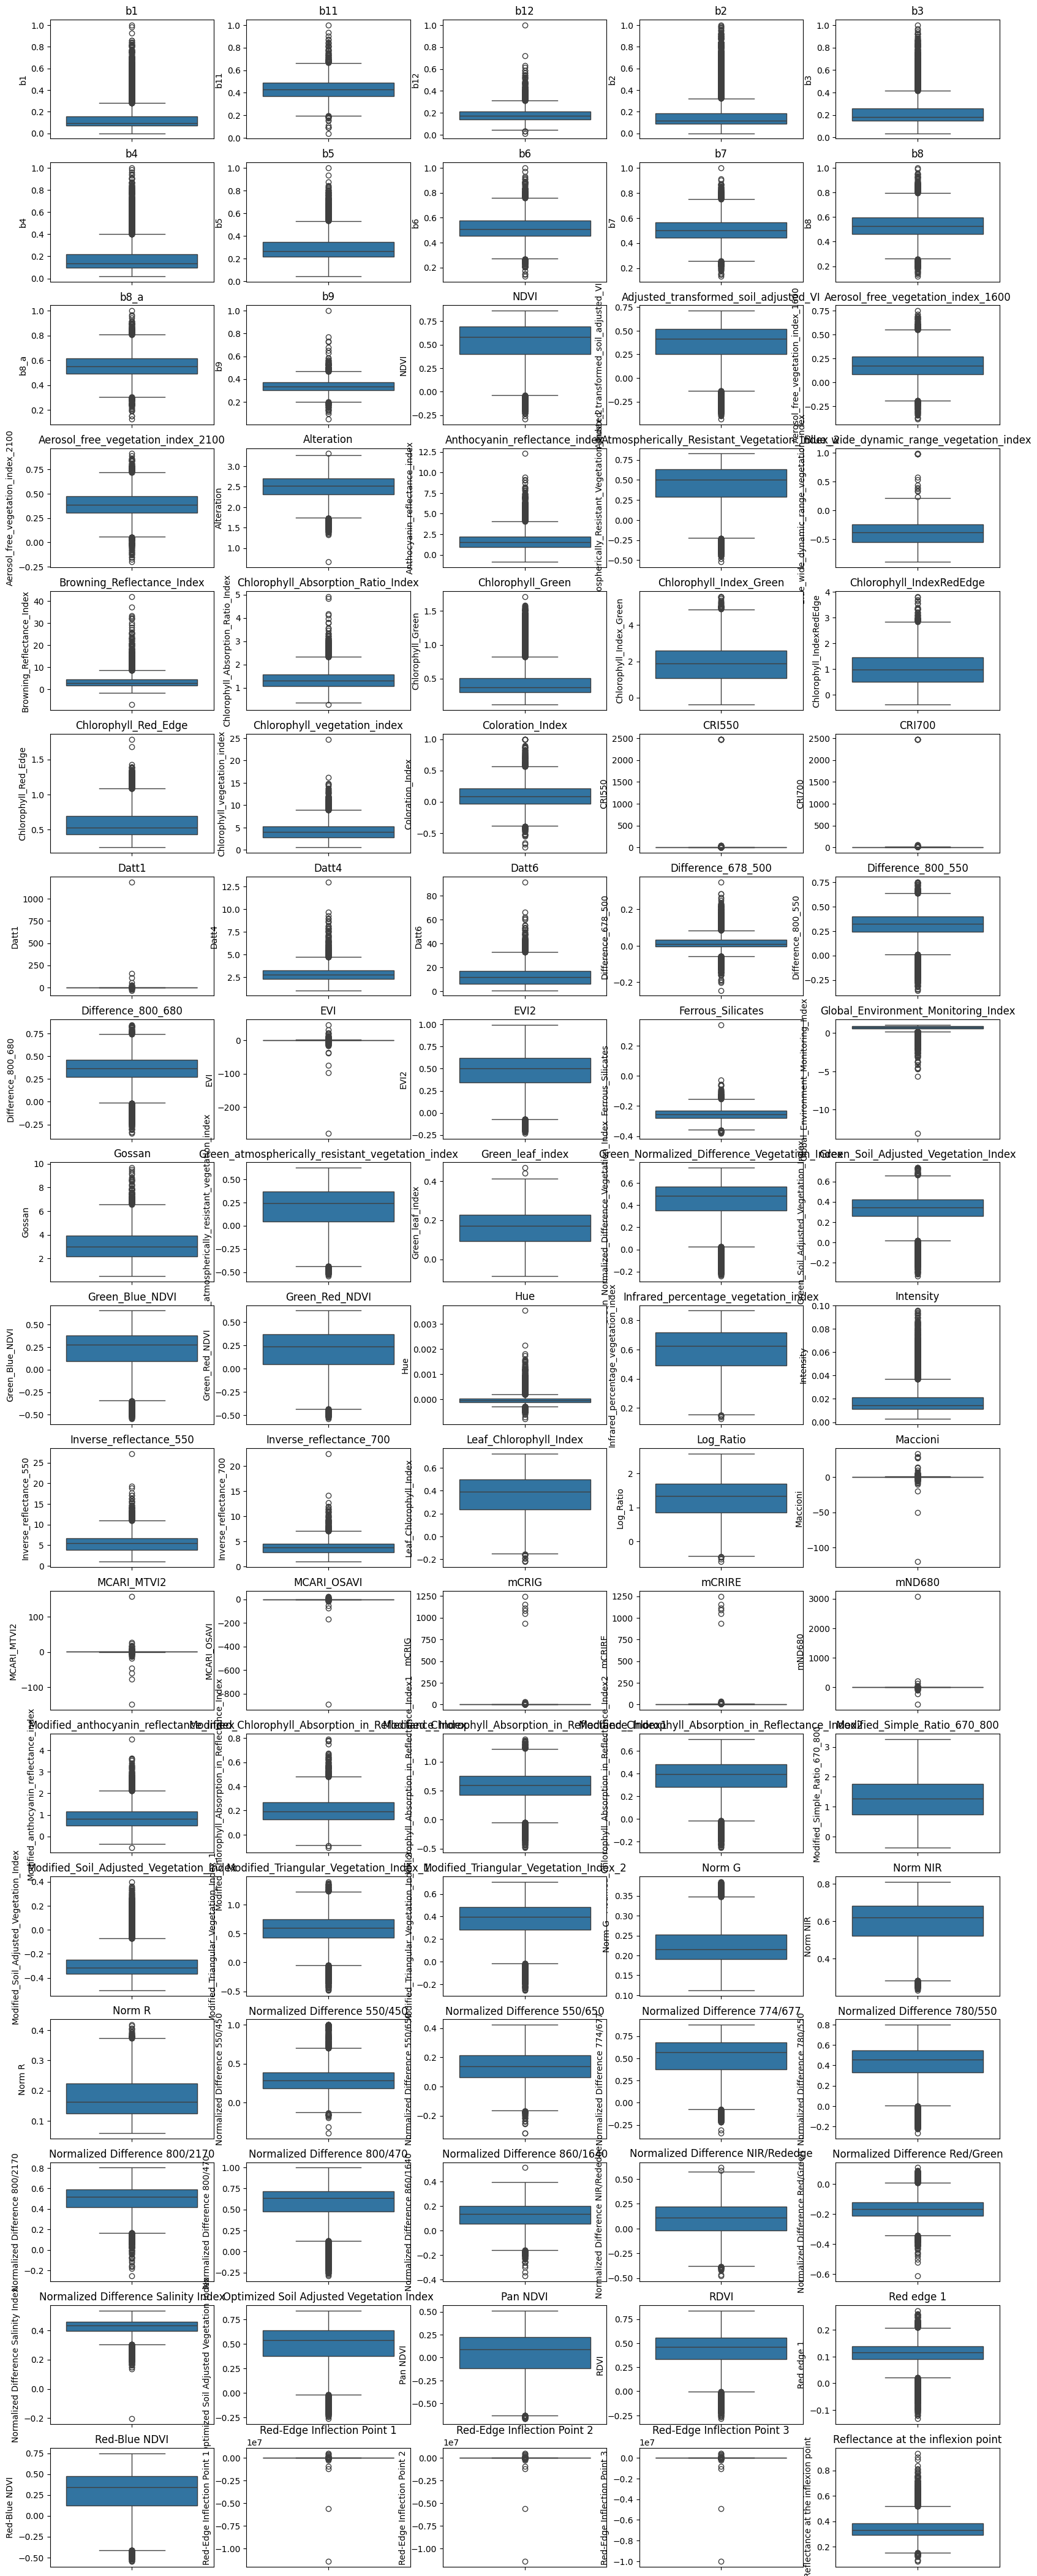

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Drop the 'id' and 'nforest_type' columns for plotting
features = train_df_new_num.columns.drop(['id', 'nforest_type'])

# Calculate the number of rows and columns for subplots
num_features = len(features)
num_cols = 5
num_rows = math.ceil(num_features / num_cols)

# Set up the matplotlib figure
plt.figure(figsize=(20, num_rows * 3))

# Create a boxplot for each feature
for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=train_df_new_num[feature])
    plt.title(feature)
    # plt.tight_layout()

plt.show()

---------------------------

## Feature Selection (Union Correlation Matrix + Mutual Information + RF Feature Importance)

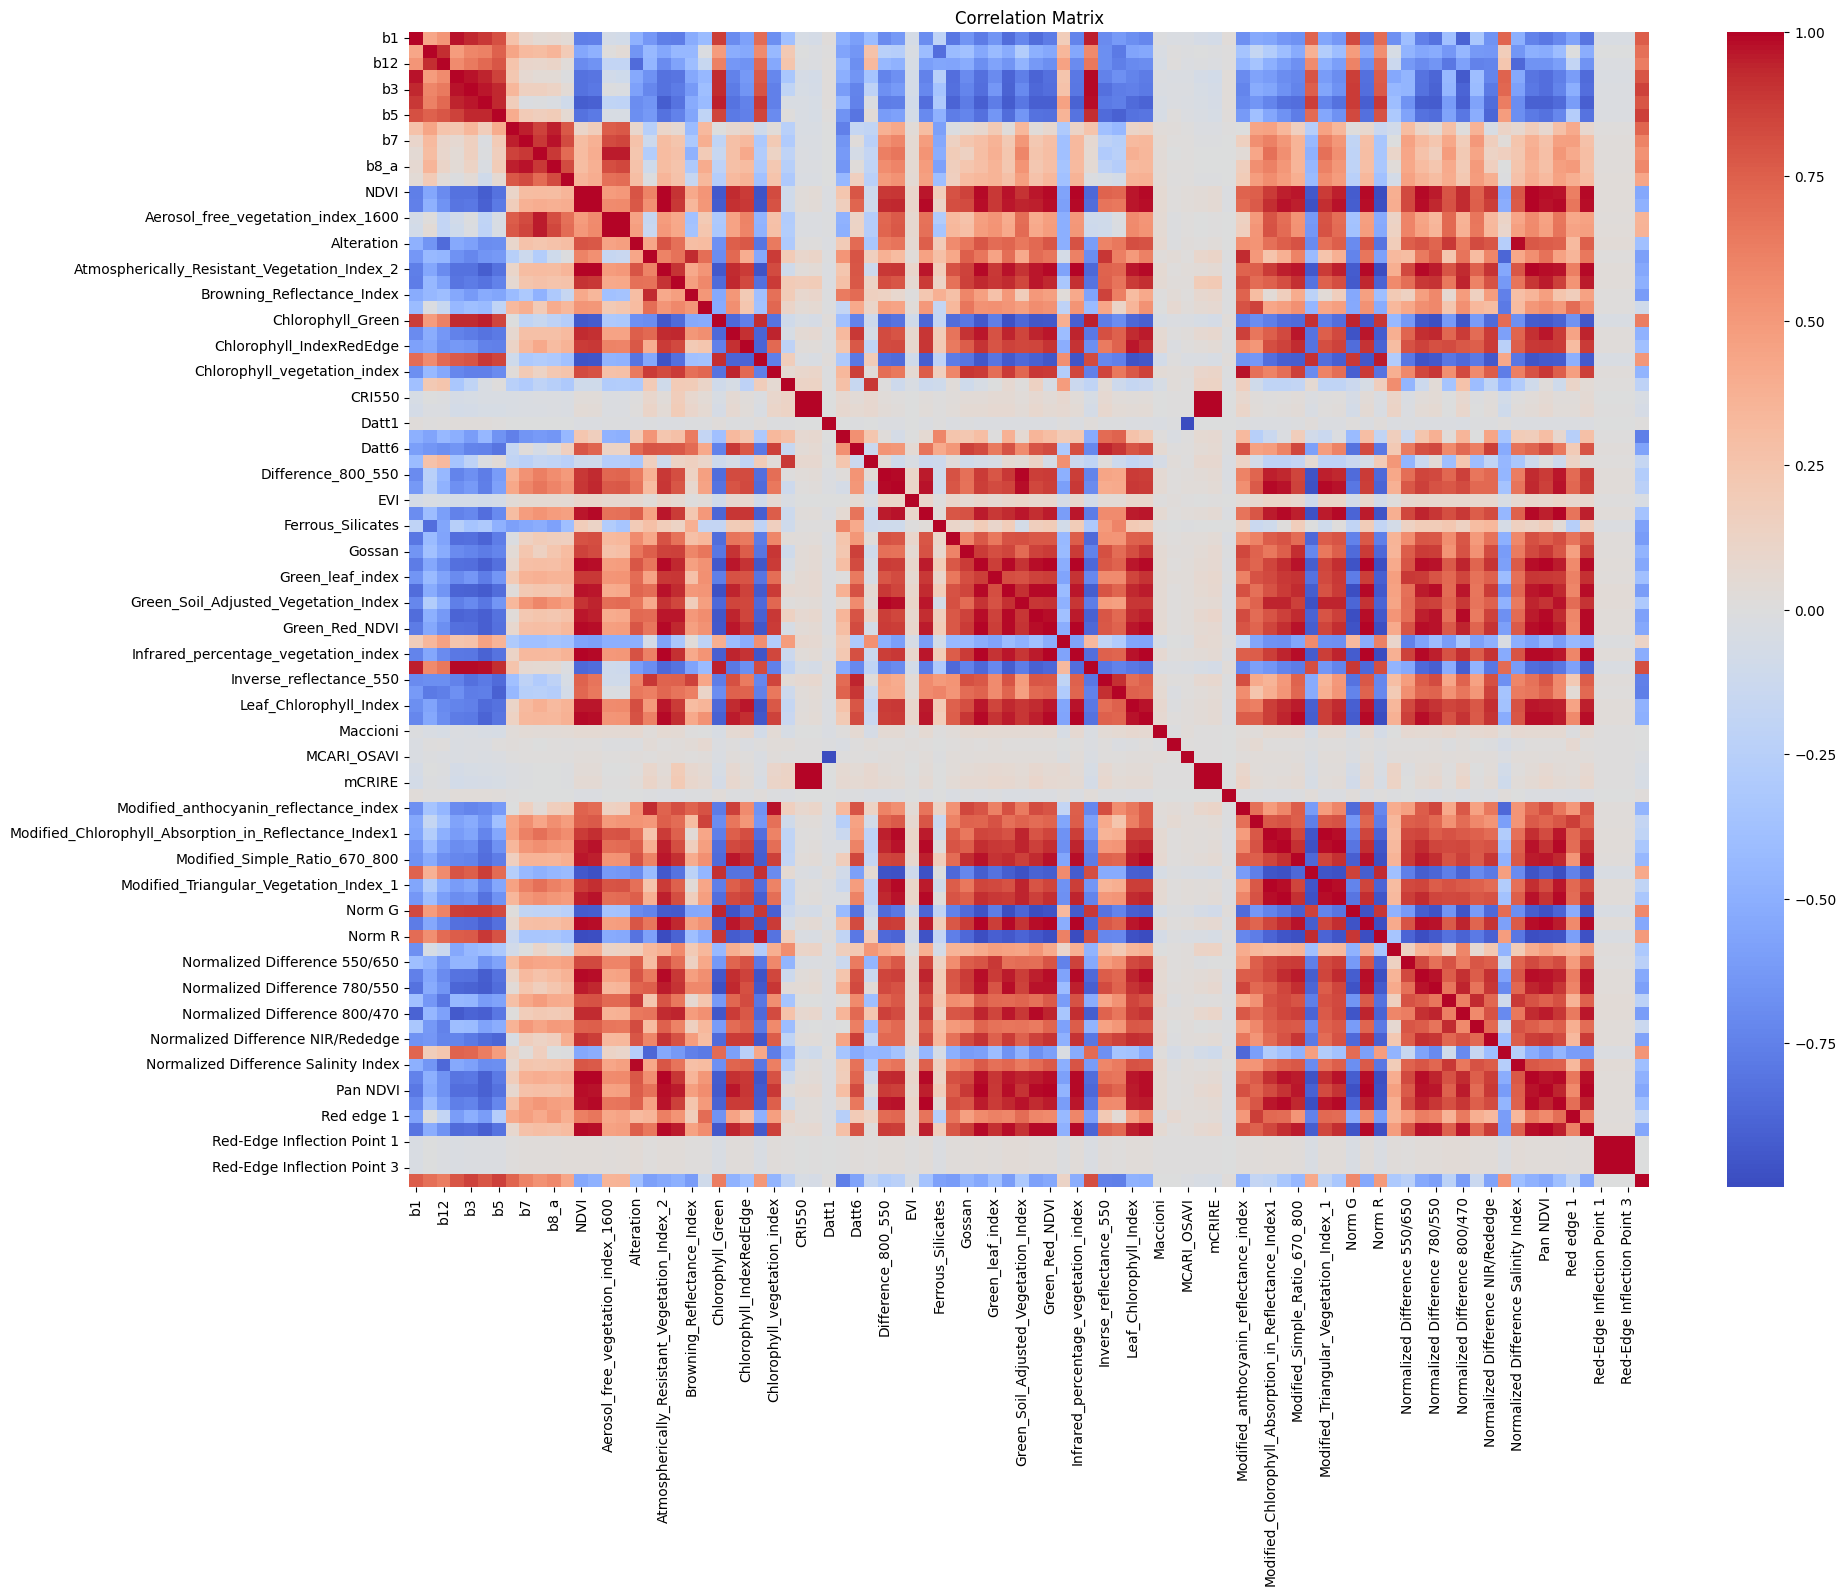

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Remove the target column for correlation analysis
X_for_select = train_df_new_num.drop(['id', 'nforest_type'], axis=1)
y_for_select = train_df_new_num['nforest_type']

# Step 1: Correlation Matrix
corr_matrix = X_for_select.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Identify and remove highly correlated features (threshold > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]
X_for_select_reduced = X_for_select.drop(columns=to_drop)

# Step 2: Mutual Information
mi = mutual_info_classif(X_for_select_reduced, y_for_select, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X_for_select_reduced.columns).sort_values(ascending=False)
plt.figure(figsize=(20, 6))
mi_series.plot.bar()
plt.title("Mutual Information of Features")
plt.show()

# Step 3: Feature Importance using Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_for_select_reduced, y_for_select)
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X_for_select_reduced.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 6))
feat_importances.plot.bar()
plt.title("Feature Importances from Random Forest")
plt.show()

# Select top N features based on mutual information and feature importance
top_features_mi = mi_series.head(20).index.tolist()
top_features_rf = feat_importances.head(20).index.tolist()

# Combine the selected features
selected_features = list(set(top_features_mi).union(set(top_features_rf)))
selected_features


In [ ]:
selected_features

['CRI550',
 'Ferrous_Silicates',
 'Brightness_TC',
 'Difference_678_500',
 'Anthocyanin_reflectance_index',
 'Maccioni',
 'NDMI ',
 'Greenness_TC',
 'mND680',
 'Green_leaf_index',
 'EVI',
 'b8',
 'Datt1',
 'Datt6',
 'b11',
 'BI',
 'MCARI',
 'b6',
 'Chlorophyll_Absorption_Ratio_Index',
 'pca3',
 'Alteration',
 'Wetness_TC',
 'b9',
 'rep']

In [ ]:
# Extend the selected_features list to include 'id' and 'nforest_type'
train_selected_features = selected_features + ['id', 'nforest_type']
test_selected_features = selected_features + ['id']

In [ ]:
train_selected_features

['CRI550',
 'Ferrous_Silicates',
 'Brightness_TC',
 'Difference_678_500',
 'Anthocyanin_reflectance_index',
 'Maccioni',
 'NDMI ',
 'Greenness_TC',
 'mND680',
 'Green_leaf_index',
 'EVI',
 'b8',
 'Datt1',
 'Datt6',
 'b11',
 'BI',
 'MCARI',
 'b6',
 'Chlorophyll_Absorption_Ratio_Index',
 'pca3',
 'Alteration',
 'Wetness_TC',
 'b9',
 'rep',
 'id',
 'nforest_type']

In [ ]:
train_df_new_num = train_df_new_num[train_selected_features]
train_df_new_num

CRI550  Ferrous_Silicates  Brightness_TC  Difference_678_500  \
0      0.001492               -889      2665.7848                 175   
1      0.002093               -901      2466.9149                  27   
2      0.000038               -944      3520.8225                -126   
3      0.002840               -871      2864.4129                 -14   
4      0.000904               -813      2640.4000                 125   
...         ...                ...            ...                 ...   
13048  0.000848               -886      2870.1640                 116   
13049  0.000055               -882      6356.7542                 144   
13050  0.000100               -859      3375.3107                  -7   
13051  0.000011              -1122      4173.9393                -223   
13052  0.001658              -1007      3282.9564                 178   

       Anthocyanin_reflectance_index  Maccioni     NDMI   Greenness_TC  \
0                           0.001092  0.691508 -0.007055      910.1103   
1                           0.001416  0.795588  0.170301     1375.6641   
2                           0.000161  0.767412  0.095489      719.4804   
3                           0.000809  0.841142  0.319372     1948.9980   
4                           0.000769  0.682388 -0.066374      693.6408   
...                              ...       ...       ...           ...   
13048                       0.000746  0.665269  0.041739      983.7048   
13049                       0.000129  0.743205  0.042785      799.2610   
13050                       0.000127  0.720197 -0.016460      301.6738   
13051                       0.000125  0.808288  0.137635     1114.9840   
13052                       0.000857  0.782785  0.150173     1584.3136   

         mND680  Green_leaf_index  ...       MCARI    b6  \
0      0.818902          0.130280  ...  198.089970  1773   
1      0.970307          0.235975  ...  129.378299  1982   
2      1.105036          0.052089  ...  227.331148  2051   
3      0.970698          0.383051  ...  113.160920  2117   
4      0.711775          0.117922  ...  188.327887  1549   
...         ...               ...  ...         ...   ...   
13048  0.866595          0.124378  ...  202.156397  1678   
13049  1.251740          0.025316  ...  337.020570  3488   
13050  0.945631          0.052888  ...  192.981470  1780   
13051  1.358265          0.059017  ...  260.728092  2511   
13052  0.821133          0.160694  ...  181.210443  1953   

       Chlorophyll_Absorption_Ratio_Index        pca3  Alteration  Wetness_TC  \
0                             3023.337425  216.061962    1.856455   -913.7096   
1                             2619.762939  -24.866739    2.292683   -513.8984   
2                              411.069764 -302.257004    1.915616   -431.1658   
3                             1145.474708  -90.372846    2.264151   -228.1074   
4                             1601.252201  421.529957    1.718833   -999.5043   
...                                   ...         ...         ...         ...   
13048                         1840.899541  314.767961    1.840607   -810.8789   
13049                          233.800269  206.329716    1.324265  -1293.3922   
13050                          581.437919 -149.974002    1.748258   -613.1801   
13051                          665.142290 -288.722605    1.942857   -468.0687   
13052                         1718.107817  456.136752    1.928967   -730.2240   

         b9         rep     id  nforest_type  
0      3039  719.761450   2002             2  
1      2690  722.675000   3212             0  
2      2683  722.626354  13312             2  
3      2955  726.631300  17020             2  
4      2043  718.728209   5967             2  
...     ...         ...    ...           ...  
13048  2100  716.808131   9185             0  
13049  6053  720.472743  13977             0  
13050  2170  719.815341    755             0  
13051  3380  724.729392   1616             2  
13052  2586  723.234608  15634  

In [ ]:
test_df_new_num = test_df_new_num[test_selected_features]
test_df_new_num

CRI550  Ferrous_Silicates  Brightness_TC  Difference_678_500  \
0     0.001297               -732      2600.8483                  64   
1     0.001000               -823      2682.3970                 -19   
2     0.001747              -1236      3736.8959                 118   
3     0.001520               -879      2982.8426                 169   
4     0.001140               -738      2499.5034                  91   
...        ...                ...            ...                 ...   
3995  0.000840               -875      3187.2816                  16   
3996  0.000842              -1191      3862.5035                 283   
3997  0.001571               -868      2875.7466                  11   
3998  0.001814              -1066      3220.5393                 -14   
3999  0.004462               -802      2291.6965                 114   

      Anthocyanin_reflectance_index  Maccioni     NDMI   Greenness_TC  \
0                          0.000728  0.762121  0.250592     1296.5002   
1                          0.000523  0.787487  0.240341     1392.3458   
2                          0.000642  0.802912  0.177642     1986.9477   
3                          0.000730  0.652740  0.061101     1128.1137   
4                          0.000787  0.817204  0.208299     1197.1871   
...                             ...       ...       ...           ...   
3995                       0.000469  0.788980  0.275150     1622.1967   
3996                       0.000513  0.715712 -0.002792     1163.5259   
3997                       0.001014  0.829249  0.341895     1896.3703   
3998                       0.000845  0.853507  0.281811     2091.1101   
3999                       0.001003  0.843263  0.192438     1268.6580   

        mND680  Green_leaf_index  ...    BI       MCARI    b6  \
0     0.765291          0.207373  ... -2303  180.408973  1821   
1     0.929066          0.220339  ... -2050  160.104735  1730   
2     0.885202          0.258712  ... -3185  204.447668  2586   
3     0.878049          0.188571  ... -1870  205.575356  1754   
4     0.821284          0.130379  ... -1814  138.308470  1487   
...        ...               ...  ...   ...         ...   ...   
3995  1.004775          0.208410  ... -2747  210.648852  2432   
3996  0.657787          0.119827  ... -2419  254.763060  2334   
3997  0.980878          0.232856  ... -2861  141.716738  2188   
3998  0.993492          0.298969  ... -3484  137.877098  2491   
3999  0.786712          0.308772  ... -2405  126.744295  1740   

      Chlorophyll_Absorption_Ratio_Index        pca3  Alteration  Wetness_TC  \
0                            1480.019790 -132.452147    2.056277   -246.5964   
1                             440.614314 -144.254176    2.191027   -289.7299   
2                            1770.457601  523.908734    2.105546   -741.0592   
3                            1910.637772  409.152604    1.775132   -860.4619   
4                             725.422962  -61.458767    2.036517   -346.0793   
...                                  ...         ...         ...         ...   
3995                          928.129070 -237.987411    2.078915   -220.5011   
3996                         1895.113458  878.644675    1.792415  -1219.3459   
3997                         1751.093609 -233.398829    2.404531   -103.8510   
3998                         1576.442324   53.247864    2.377261   -344.2257   
3999                         1041.535450  -61.248379    2.275040   -407.6127   

        b9         rep     id  
0     2595  723.649897  13467  
1     2582  723.433794  12719  
2     3149  723.417643   1054  
3     2345  715.110104  13747  
4     2193  726.563268   9453  
...    ...         ...    ...  
3995  3312  721.811398    115  
3996  2856  718.814904  10654  
3997  3087  724.897582   5718  
3998  3161  727.295861  13054  
3999  2630  727.915210   6539  

[4000 rows x 25 columns]

--------

# Step 1: Initial Training and Hyperparameter Tuning with Optuna

In [ ]:
# !pip uninstall lightgbm
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !pip install lightgbm

In [ ]:
# !pip install catboost

In [ ]:
# !pip install optuna-integration

In [52]:
# Assign X, y for splittinf train and val
X = train_df_new_num.drop(['id', 'nforest_type'], axis=1)

y = train_df_new_num['nforest_type']

**OptunaSearchCV:** hyperparameter tuning for each classifier (results compiled into df)

In [53]:
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from imblearn.over_sampling import SMOTE

In [54]:
# Set parameters
VAL_SPLIT = 0.15
CV_NUM = 8
SCALE = MinMaxScaler()
seed = 42


# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, stratify=y, random_state=seed)

# Scale the data
X_train_scaled = SCALE.fit_transform(X_train)
X_val_scaled = SCALE.transform(X_val)

# Balance the classes using SMOTE
smote = SMOTE(random_state=seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify the shapes of the resulting datasets

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"y_val shape: {y_val.shape}")


X shape: (13053, 52)
y shape: (13053,)
X_train shape: (11095, 52)
y_train shape: (11095,)
X_train_balanced shape: (14955, 52)
y_train_balanced shape: (14955,)
X_val_scaled shape: (1958, 52)
y_val shape: (1958,)


In [55]:
# Define K-Fold cross-validation
kfold = StratifiedKFold(n_splits=CV_NUM, shuffle=True, random_state=seed)

# Define classifiers and their parameter grids
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'solver': optuna.distributions.CategoricalDistribution(['lbfgs', 'saga'])
    }),
    "KNeighborsClassifier": (KNeighborsClassifier(), {
        'n_neighbors': optuna.distributions.IntDistribution(1, 50),
        'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance'])
    }),
    "DecisionTreeClassifier": (DecisionTreeClassifier(random_state=seed), {
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16)
    }),
    "AdaBoostClassifier": (AdaBoostClassifier(DecisionTreeClassifier(random_state=seed), random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True)
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
    }),
    "GradientBoostingClassifier": (GradientBoostingClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32)
    }),
    "SVC": (SVC(), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid'])
    }),
    "MLPClassifier": (MLPClassifier(random_state=seed), {
        'hidden_layer_sizes': optuna.distributions.CategoricalDistribution([(50,), (100,), (50, 50),
                                                                            (100, 100), (50,50,50), (50,100,50)]), #add (50,50,50), (50,100,50)
        'activation': optuna.distributions.CategoricalDistribution(['relu', 'tanh', 'logistic','identity']),
        'alpha': optuna.distributions.FloatDistribution(1e-4, 1e-2, log=True),
        'learning_rate_init': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_iter': optuna.distributions.IntDistribution(200, 1000)
    }),
    "XGBClassifier": (XGBClassifier(random_state=seed, tree_method='gpu_hist'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_child_weight': optuna.distributions.IntDistribution(1, 10)
    }),
    "LGBMClassifier": (LGBMClassifier(random_state=seed, device='gpu'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'num_leaves': optuna.distributions.IntDistribution(2, 256),
        'boosting_type': optuna.distributions.CategoricalDistribution(['gbdt', 'dart'])
    }),
    "CatBoostClassifier": (CatBoostClassifier(random_state=seed, verbose=0, task_type='GPU'), {
        'iterations': optuna.distributions.IntDistribution(50, 1000),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'depth': optuna.distributions.IntDistribution(1, 32) #from 16
    })
}

# Perform hyperparameter tuning using Optuna
optuna_results = []

for name, (classifier, param_grid) in classifiers.items():
    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    optuna_search.fit(X_train_balanced, y_train_balanced)
    best_estimator = optuna_search.best_estimator_
    best_params = optuna_search.best_params_
    best_score = optuna_search.best_score_
    print(f'[model: {name}]')
    print("Best Parameters: ", best_params)
    print("Best Estimator: ", best_estimator)
    print("Best Score: ", best_score)
    print('---------------------')
    optuna_results.append((name, best_score, best_params, best_estimator))

# Compile the results
optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

optuna_results_df.to_csv(f'{results_path}/optuna_results_df_feat04_RFECV.csv', index=False)

/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution

[model: LogisticRegression]
Best Parameters:  {'C': 92.74523606367225, 'solver': 'lbfgs'}
Best Estimator:  LogisticRegression(C=92.74523606367225, max_iter=1000)
Best Score:  0.6706788282217893
---------------------


[I 2024-06-06 16:47:50,225] Trial 3 finished with value: 0.7338676635107567 and parameters: {'n_neighbors': 29, 'weights': 'distance'}. Best is trial 3 with value: 0.7338676635107567.
[I 2024-06-06 16:47:50,356] Trial 7 finished with value: 0.7284517586401261 and parameters: {'n_neighbors': 35, 'weights': 'distance'}. Best is trial 3 with value: 0.7338676635107567.
[I 2024-06-06 16:47:50,392] Trial 2 finished with value: 0.6746915262529936 and parameters: {'n_neighbors': 48, 'weights': 'uniform'}. Best is trial 3 with value: 0.7338676635107567.
[I 2024-06-06 16:47:50,400] Trial 4 finished with value: 0.735205277207921 and parameters: {'n_neighbors': 30, 'weights': 'distance'}. Best is trial 4 with value: 0.735205277207921.
[I 2024-06-06 16:47:50,461] Trial 0 finished with value: 0.6822467904424282 and parameters: {'n_neighbors': 35, 'weights': 'uniform'}. Best is trial 4 with value: 0.735205277207921.
[I 2024-06-06 16:47:50,468] Trial 1 finished with value: 0.7224343210215649 and param

[model: KNeighborsClassifier]
Best Parameters:  {'n_neighbors': 30, 'weights': 'distance'}
Best Estimator:  KNeighborsClassifier(n_neighbors=30, weights='distance')
Best Score:  0.735205277207921
---------------------


[I 2024-06-06 16:47:52,584] Trial 2 finished with value: 0.5297890146865692 and parameters: {'max_depth': 2, 'min_samples_split': 2}. Best is trial 2 with value: 0.5297890146865692.
[I 2024-06-06 16:47:54,399] Trial 4 finished with value: 0.6038106969038892 and parameters: {'max_depth': 5, 'min_samples_split': 10}. Best is trial 4 with value: 0.6038106969038892.
[I 2024-06-06 16:47:56,990] Trial 1 finished with value: 0.6648589210965286 and parameters: {'max_depth': 10, 'min_samples_split': 4}. Best is trial 1 with value: 0.6648589210965286.
[I 2024-06-06 16:47:57,436] Trial 8 finished with value: 0.6654607399650361 and parameters: {'max_depth': 11, 'min_samples_split': 3}. Best is trial 8 with value: 0.6654607399650361.
[I 2024-06-06 16:47:58,570] Trial 3 finished with value: 0.6779662120210699 and parameters: {'max_depth': 15, 'min_samples_split': 3}. Best is trial 3 with value: 0.6779662120210699.
[I 2024-06-06 16:47:58,958] Trial 7 finished with value: 0.6704773635705559 and parame

[model: DecisionTreeClassifier]
Best Parameters:  {'max_depth': 15, 'min_samples_split': 3}
Best Estimator:  DecisionTreeClassifier(max_depth=15, min_samples_split=3, random_state=42)
Best Score:  0.6779662120210699
---------------------


/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[model: AdaBoostClassifier]
Best Parameters:  {'n_estimators': 400, 'learning_rate': 0.08057840201005566}
Best Estimator:  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                   learning_rate=0.08057840201005566, n_estimators=400,
                   random_state=42)
Best Score:  0.6674686984088835
---------------------


[I 2024-06-06 16:48:35,987] Trial 1 finished with value: 0.5782673181632203 and parameters: {'n_estimators': 114, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.5782673181632203.
[I 2024-06-06 16:49:07,838] Trial 3 finished with value: 0.5164819043041118 and parameters: {'n_estimators': 692, 'max_depth': 1, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.5782673181632203.
[I 2024-06-06 16:50:17,097] Trial 8 finished with value: 0.6629881932343928 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.6629881932343928.
[I 2024-06-06 16:51:11,186] Trial 5 finished with value: 0.6637906899225471 and parameters: {'n_estimators': 507, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 5 with value: 0.6637906899225471.
[I 2024-06-06 16:51:25,160] Trial 4 finished with value: 0.6629884078248256 and parameters: {'

[model: RandomForestClassifier]
Best Parameters:  {'n_estimators': 417, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2}
Best Estimator:  RandomForestClassifier(max_depth=24, min_samples_leaf=2, n_estimators=417,
                       random_state=42)
Best Score:  0.7830152030168553
---------------------


[I 2024-06-06 17:39:51,337] Trial 9 finished with value: 0.6842524241565882 and parameters: {'n_estimators': 64, 'learning_rate': 0.01799029442704708, 'max_depth': 28}. Best is trial 9 with value: 0.6842524241565882.
[I 2024-06-06 17:53:18,051] Trial 0 finished with value: 0.6875299353653617 and parameters: {'n_estimators': 77, 'learning_rate': 0.035926884263033206, 'max_depth': 27}. Best is trial 0 with value: 0.6875299353653617.
[I 2024-06-06 18:53:36,980] Trial 8 finished with value: 0.7619518645047396 and parameters: {'n_estimators': 955, 'learning_rate': 0.08857633554432975, 'max_depth': 4}. Best is trial 8 with value: 0.7619518645047396.
[I 2024-06-06 19:13:54,059] Trial 2 finished with value: 0.7816099575683185 and parameters: {'n_estimators': 692, 'learning_rate': 0.0963873704456, 'max_depth': 19}. Best is trial 2 with value: 0.7816099575683185.
[I 2024-06-06 20:58:59,269] Trial 7 finished with value: 0.6863257969173369 and parameters: {'n_estimators': 387, 'learning_rate': 0.0

[model: GradientBoostingClassifier]
Best Parameters:  {'n_estimators': 364, 'learning_rate': 0.027378582019044452, 'max_depth': 18}
Best Estimator:  GradientBoostingClassifier(learning_rate=0.027378582019044452, max_depth=18,
                           n_estimators=364, random_state=42)
Best Score:  0.7822790147724055
---------------------


/tmp/ipykernel_52286/570701526.py:68: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-07 02:57:40,424] A new study created in memory with name: no-name-6f8c4621-2455-4d58-908d-b489d34c35ed
[I 2024-06-07 02:58:20,036] Trial 1 finished with value: 0.6740890636131879 and parameters: {'C': 0.1625112784335491, 'kernel': 'poly'}. Best is trial 1 with value: 0.6740890636131879.
[I 2024-06-07 02:58:23,446] Trial 0 finished with value: 0.6258770668635176 and parameters: {'C': 0.04637329975921091, 'kernel': 'linear'}. Best is trial 1 with value: 0.6740890636131879.
[I 2024-06-07 02:58:33,302] Trial 9 finished with value: 0.5770649322037293 and parameters: {'C': 0.0019025796655269221, 'kernel': 'poly'}. Best is trial 1 with value: 0.6740890636131879.
[I 2024-06-07 02:58:35,016] Trial 3 finished with value: 0.688867227176877 and parameters: {'C': 4.796943638740048, 'kernel': 'rbf'}. B

[model: SVC]
Best Parameters:  {'C': 4.796943638740048, 'kernel': 'rbf'}
Best Estimator:  SVC(C=4.796943638740048)
Best Score:  0.688867227176877
---------------------


[I 2024-06-07 03:01:17,743] Trial 5 finished with value: 0.3333333333333333 and parameters: {'hidden_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'alpha': 0.0007134009513744303, 'learning_rate_init': 0.08575401568749194, 'max_iter': 437}. Best is trial 5 with value: 0.3333333333333333.
[I 2024-06-07 03:01:32,897] Trial 4 finished with value: 0.632696071278358 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'identity', 'alpha': 0.00013809251683653912, 'learning_rate_init': 0.03219466018736888, 'max_iter': 524}. Best is trial 4 with value: 0.632696071278358.
[I 2024-06-07 03:01:44,610] Trial 3 finished with value: 0.3965214533208585 and parameters: {'hidden_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'alpha': 0.005037249440163739, 'learning_rate_init': 0.03679553377126883, 'max_iter': 784}. Best is trial 4 with value: 0.632696071278358.
[I 2024-06-07 03:02:17,726] Trial 1 finished with value: 0.6261465566819169 and parameters: {'hidden_layer_sizes': (100, 100), 'a

[model: MLPClassifier]
Best Parameters:  {'hidden_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'alpha': 0.0016550657574483888, 'learning_rate_init': 0.005092509452768045, 'max_iter': 255}
Best Estimator:  MLPClassifier(activation='tanh', alpha=0.0016550657574483888,
              hidden_layer_sizes=(50, 50, 50),
              learning_rate_init=0.005092509452768045, max_iter=255,
              random_state=42)
Best Score:  0.7326654206115542
---------------------


[03:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"
[03:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"
[03:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"
[03:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[03:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprec

[model: XGBClassifier]
Best Parameters:  {'n_estimators': 588, 'learning_rate': 0.09736173248740738, 'max_depth': 25, 'min_child_weight': 2}
Best Estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09736173248740738,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=588, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best Score:  0.7985282672823981
---------------------
[LightGBM] [

[I 2024-06-07 03:19:38,528] Trial 2 finished with value: 0.5816774462594025 and parameters: {'n_estimators': 648, 'learning_rate': 0.0010215290554353089, 'num_leaves': 4, 'boosting_type': 'dart'}. Best is trial 2 with value: 0.5816774462594025.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13085, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.65 MB) transferred to GPU in 0.006349 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098536
[LightGBM] [Info] Start training from score -1.098765
[LightGBM] [Info] Start training from score -1.098536
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13085, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bin

[I 2024-06-07 03:37:24,588] Trial 6 finished with value: 0.7860900335619436 and parameters: {'n_estimators': 270, 'learning_rate': 0.0324909273991376, 'num_leaves': 80, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7860900335619436.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13085, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.65 MB) transferred to GPU in 0.005385 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098536
[LightGBM] [Info] Start training from score -1.098765
[LightGBM] [Info] Start training from score -1.098536
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13085, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bin

[I 2024-06-07 03:47:04,244] Trial 8 finished with value: 0.7417584398417181 and parameters: {'n_estimators': 464, 'learning_rate': 0.024446912152610193, 'num_leaves': 59, 'boosting_type': 'dart'}. Best is trial 6 with value: 0.7860900335619436.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13086, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.65 MB) transferred to GPU in 0.004729 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13086, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bin

[I 2024-06-07 03:51:39,834] Trial 9 finished with value: 0.6845862911047974 and parameters: {'n_estimators': 650, 'learning_rate': 0.0014654619965746333, 'num_leaves': 47, 'boosting_type': 'dart'}. Best is trial 6 with value: 0.7860900335619436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-07 03:58:20,020] Trial 5 finished with value: 0.7872942435401127 and parameters: {'n_estimators': 212, 'learning_rate': 0.06867240243359313, 'num_leaves': 222, 'boosting_type': 'dart'}. Best is trial 5 with value: 0.7872942435401127.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13085, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.65 MB) transferred to GPU in 0.004797 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098536
[LightGBM] [Info] Start training from score -1.098765
[LightGBM] [Info] Start training from score -1.098536
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13086, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bin

[I 2024-06-07 04:22:23,943] Trial 1 finished with value: 0.7527916069389963 and parameters: {'n_estimators': 419, 'learning_rate': 0.002683690021619174, 'num_leaves': 219, 'boosting_type': 'gbdt'}. Best is trial 5 with value: 0.7872942435401127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-07 04:23:15,649] Trial 7 finished with value: 0.7419588673058599 and parameters: {'n_estimators': 701, 'learning_rate': 0.006944020239062984, 'num_leaves': 113, 'boosting_type': 'dart'}. Best is trial 5 with value: 0.7872942435401127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-07 04:32:13,997] Trial 0 finished with value: 0.790772110682884 and parameters: {'n_estimators': 582, 'learning_rate': 0.008939412238314697, 'num_leaves': 200, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.790772110682884.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-07 04:34:31,102] Trial 4 finished with value: 0.8046792516802431 and parameters: {'n_estimators': 939, 'learning_rate': 0.06767043690171617, 'num_leaves': 232, 'boosting_type': 'gbdt'}. Best is trial 4 with value: 0.8046792516802431.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13086, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.65 MB) transferred to GPU in 0.013503 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 13086, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bin

[I 2024-06-07 04:37:48,477] Trial 3 finished with value: 0.7950508293204922 and parameters: {'n_estimators': 829, 'learning_rate': 0.019964935368882192, 'num_leaves': 255, 'boosting_type': 'dart'}. Best is trial 4 with value: 0.8046792516802431.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.74 MB) transferred to GPU in 0.003647 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/tmp/ipykernel_52286/570701526.py:68: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-07 04:38:22,757] A new study created in memory with name: no-name-bd741924-20a9-40d0-b97a-2ec85b27d383
TBB Warning: The number of workers is currently limited to 15. The request for 63 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
[W 2024-06-07 04:38:29,357] Trial 6 failed with parameters: {'iterations': 894, 'learning_rate': 0.017587262683322172, 'depth': 27} because of the following error: The value nan is not acceptable.
[W 2024-06-07 04:38:29,374] Trial 0 failed with parameters: {'iterations': 943, 'learning_rate': 0.0032764430369663

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 526, 'learning_rate': 0.005872551109295629, 'depth': 14}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7fb68c3d5d30>
Best Score:  0.7168160931379701
---------------------
                         Model  Best Score  \
0           LogisticRegression    0.670679   
1         KNeighborsClassifier    0.735205   
2       DecisionTreeClassifier    0.677966   
3           AdaBoostClassifier    0.667469   
4       RandomForestClassifier    0.783015   
5   GradientBoostingClassifier    0.782279   
6                          SVC    0.688867   
7                MLPClassifier    0.732665   
8                XGBClassifier    0.798528   
9               LGBMClassifier    0.804679   
10          CatBoostClassifier    0.716816   

                                      Best Parameters  \
0         {'C': 92.74523606367225, 'solver': 'lbfgs'}   
1          {'n_neighbors': 30, 'weights': 'distance'}   
2           {'max_depth': 1

In [56]:
optuna_results

[('LogisticRegression',
  0.6706788282217893,
  {'C': 92.74523606367225, 'solver': 'lbfgs'},
  LogisticRegression(C=92.74523606367225, max_iter=1000)),
 ('KNeighborsClassifier',
  0.735205277207921,
  {'n_neighbors': 30, 'weights': 'distance'},
  KNeighborsClassifier(n_neighbors=30, weights='distance')),
 ('DecisionTreeClassifier',
  0.6779662120210699,
  {'max_depth': 15, 'min_samples_split': 3},
  DecisionTreeClassifier(max_depth=15, min_samples_split=3, random_state=42)),
 ('AdaBoostClassifier',
  0.6674686984088835,
  {'n_estimators': 400, 'learning_rate': 0.08057840201005566},
  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                     learning_rate=0.08057840201005566, n_estimators=400,
                     random_state=42)),
 ('RandomForestClassifier',
  0.7830152030168553,
  {'n_estimators': 417,
   'max_depth': 24,
   'min_samples_split': 2,
   'min_samples_leaf': 2},
  RandomForestClassifier(max_depth=24, min_samples_leaf=2, n_estimators=417,


### *** if error occurred during hyperparams tuning

In [ ]:
###for error debugging
optuna_results_df_err = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
optuna_results_df_err.to_csv(f'{results_path}/optuna_results_df_feat01-not-finished.csv', index=False)

In [ ]:
optuna_results_df_err['Model']

0            LogisticRegression
1          KNeighborsClassifier
2        DecisionTreeClassifier
3            AdaBoostClassifier
4        RandomForestClassifier
5    GradientBoostingClassifier
6                           SVC
7                 MLPClassifier
8                 XGBClassifier
Name: Model, dtype: object

In [ ]:
# Perform hyperparameter tuning using Optuna
optuna_results = []

# Skip models that have already been trained
trained_models = optuna_results_df_err['Model'].tolist()

for name, (classifier, param_grid) in classifiers.items():
    if name in trained_models:
        print(f'Skipping already trained model: {name}')
        continue

    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    try:
        optuna_search.fit(X_train, y_train_balanced)
        best_estimator = optuna_search.best_estimator_
        best_params = optuna_search.best_params_
        best_score = optuna_search.best_score_
        print(f'[model: {name}]')
        print("Best Parameters: ", best_params)
        print("Best Estimator: ", best_estimator)
        print("Best Score: ", best_score)
        print('---------------------')
        optuna_results.append((name, best_score, best_params))
    except Exception as e:
        print(f'Error training model {name}: {e}')

# Compile the results
new_optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters"])

# Combine with previous results
combined_optuna_results_df = pd.concat([optuna_results_df, new_optuna_results_df], ignore_index=True)
print(combined_optuna_results_df)

# Save the combined results
combined_optuna_results_df.to_csv(f'{results_path}/combined_optuna_results_df_feat01.csv', index=False)
print(f"Combined results saved to: {results_path}/combined_optuna_results_df_feat01.csv")

<ipython-input-20-cebc5fe5e400>:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-05 09:07:08,020] A new study created in memory with name: no-name-344aaf52-d57c-447e-8ce0-ebbc2191f1c2


Skipping already trained model: LogisticRegression
Skipping already trained model: KNeighborsClassifier
Skipping already trained model: DecisionTreeClassifier
Skipping already trained model: AdaBoostClassifier
Skipping already trained model: RandomForestClassifier
Skipping already trained model: GradientBoostingClassifier
Skipping already trained model: SVC
Skipping already trained model: MLPClassifier
Skipping already trained model: XGBClassifier


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:08,974] Trial 5 failed with parameters: {'n_estimators': 79, 'learning_rate': 0.19188234555422495, 'num_leaves': 23, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,978] Trial 5 failed with value nan.
[W 2024-06-05 09:07:08,988] Trial 3 failed with parameters: {'n_estimators': 184, 'learning_rate': 0.13362042989298442, 'num_leaves': 93, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,992] Trial 3 failed with value nan.
[W 2024-06-05 09:07:08,994] Trial 2 failed with parameters: {'n_es

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 14976, number of used features: 29
Error training model LGBMClassifier: No OpenCL device found


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,398] Trial 1 failed with parameters: {'iterations': 59, 'learning_rate': 0.404665400351513, 'depth': 9} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:14,406] Trial 1 failed with value nan.
/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,614]

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 150, 'learning_rate': 0.0151103585762203, 'depth': 13}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7c54703bffa0>
Best Score:  0.6694043803418803
---------------------
                        Model  Best Score  \
0          LogisticRegression    0.647903   
1        KNeighborsClassifier    0.732505   
2      DecisionTreeClassifier    0.653846   
3          AdaBoostClassifier    0.655115   
4      RandomForestClassifier    0.765425   
5  GradientBoostingClassifier    0.781317   
6                         SVC    0.685029   
7               MLPClassifier    0.691306   
8               XGBClassifier    0.778646   
9          CatBoostClassifier    0.669404   

                                     Best Parameters  
0        {'C': 8.490782592210358, 'solver': 'lbfgs'}  
1          {'n_neighbors': 9, 'weights': 'distance'}  
2          {'max_depth': 31, 'min_samples_split': 2}  
3  {'n_estimators': 180, 'learning_ra

In [ ]:
combined_optuna_results_df

Model  Best Score  \
0          LogisticRegression    0.647903   
1        KNeighborsClassifier    0.732505   
2      DecisionTreeClassifier    0.653846   
3          AdaBoostClassifier    0.655115   
4      RandomForestClassifier    0.765425   
5  GradientBoostingClassifier    0.781317   
6                         SVC    0.685029   
7               MLPClassifier    0.691306   
8               XGBClassifier    0.778646   
9          CatBoostClassifier    0.669404   

                                     Best Parameters  
0        {'C': 8.490782592210358, 'solver': 'lbfgs'}  
1          {'n_neighbors': 9, 'weights': 'distance'}  
2          {'max_depth': 31, 'min_samples_split': 2}  
3  {'n_estimators': 180, 'learning_rate': 0.02880...  
4  {'n_estimators': 130, 'max_depth': 21, 'min_sa...  
5  {'n_estimators': 154, 'learning_rate': 0.11829...  
6           {'C': 4.61538732142158, 'kernel': 'rbf'}  
7  {'hidden_layer_sizes': (100, 100), 'activation...  
8  {'n_estimators': 106, 'learning_rate': 0.09181...  
9  {'iterations': 150, 'learning_rate': 0.0151103...

In [ ]:
optuna_results_df = combined_optuna_results_df.copy()

---------------------------

------------------------------
# Step 2: Select Top Models
## (Include MLPClassifier in the top models)

In [ ]:
# optuna_results_df = pd.read_csv('results/multmodels_optuna/features01-suggest/optuna_results_df_feat04.csv')

In [61]:
# Compile the results
optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

# Select top models based on validation accuracy
top_6_models = optuna_results_df.sort_values(by='Best Score', ascending=False).head(6)

                         Model  Best Score  \
0           LogisticRegression    0.670679   
1         KNeighborsClassifier    0.735205   
2       DecisionTreeClassifier    0.677966   
3           AdaBoostClassifier    0.667469   
4       RandomForestClassifier    0.783015   
5   GradientBoostingClassifier    0.782279   
6                          SVC    0.688867   
7                MLPClassifier    0.732665   
8                XGBClassifier    0.798528   
9               LGBMClassifier    0.804679   
10          CatBoostClassifier    0.716816   

                                      Best Parameters  \
0         {'C': 92.74523606367225, 'solver': 'lbfgs'}   
1          {'n_neighbors': 30, 'weights': 'distance'}   
2           {'max_depth': 15, 'min_samples_split': 3}   
3   {'n_estimators': 400, 'learning_rate': 0.08057...   
4   {'n_estimators': 417, 'max_depth': 24, 'min_sa...   
5   {'n_estimators': 364, 'learning_rate': 0.02737...   
6           {'C': 4.796943638740048, 'kernel': '

In [62]:
top_6_models

Model  Best Score  \
9              LGBMClassifier    0.804679   
8               XGBClassifier    0.798528   
4      RandomForestClassifier    0.783015   
5  GradientBoostingClassifier    0.782279   
1        KNeighborsClassifier    0.735205   
7               MLPClassifier    0.732665   

                                     Best Parameters  \
9  {'n_estimators': 939, 'learning_rate': 0.06767...   
8  {'n_estimators': 588, 'learning_rate': 0.09736...   
4  {'n_estimators': 417, 'max_depth': 24, 'min_sa...   
5  {'n_estimators': 364, 'learning_rate': 0.02737...   
1         {'n_neighbors': 30, 'weights': 'distance'}   
7  {'hidden_layer_sizes': (50, 50, 50), 'activati...   

                                      Best Estimator  
9  LGBMClassifier(device='gpu', learning_rate=0.0...  
8  XGBClassifier(base_score=None, booster=None, c...  
4  (DecisionTreeClassifier(max_depth=24, max_feat...  
5  ([DecisionTreeRegressor(criterion='friedman_ms...  
1  KNeighborsClassifier(n_neighbors=30, weights='...  
7  MLPClassifier(activation='tanh', alpha=0.00165...

# Step 3: Predictions

## Retrain each top model(full training data)

In [64]:
X_combined = np.concatenate([X_train_balanced, X_val])
y_combined = np.concatenate([y_train_balanced, y_val])
print(X_combined.shape, y_combined.shape)

(16913, 52) (16913,)


In [ ]:
import json
from sklearn.metrics import accuracy_score

retrained_models = []
for index, row in top_6_models.iterrows():
    model_name = row['Model']
    best_estimator = row['Best Estimator']
    best_params = row['Best Parameters']
    
    # Ensure best_params is a dictionary
    if isinstance(best_params, str):
        best_params = json.loads(best_params)  # Convert string representation of dictionary to actual dictionary
    if isinstance(best_estimator, str):
        best_estimator = globals()[model_name](**best_params)
        
    # Fit the model on the combined dataset
    best_estimator.fit(X_combined, y_combined)
    retrained_models.append((model_name, best_estimator))

# # Evaluate fine-tuned models on the validation set
# retrained_models_acc = []
# for model_name, model in retrained_models:
#     y_val_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_val_pred)
#     retrained_models_acc.append((model_name, accuracy))
#     print(f'Validation Accuracy for {model_name}: {accuracy}')

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 16913, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52 dense feature groups (0.84 MB) transferred to GPU in 0.005166 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.092012
[LightGBM] [Info] Start training from score -1.146696
[LightGBM] [Info] Start training from score -1.059080
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [06:35:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
# sorted_retrained_models_acc = sorted(retrained_models_acc, key=lambda x: x[1], reverse=True)
# sorted_retrained_models_acc

In [ ]:
# retrained_models_dict = dict(retrained_models)
# sorted_retrained_models = [(model_name, retrained_models_dict[model_name]) for model_name, _ in sorted_retrained_models_acc]
# print(sorted_retrained_models)
sorted_retrained_models = retrained_models

## Voting Classifier

In [ ]:
# Custom Voting Classifier Implementation
test_ids = test_df_new_num['id']
test_features = test_df_new_num.drop(columns=['id'])

test_features.columns = test_features.columns.astype(str)

test_features.replace([np.inf, -np.inf], np.nan, inplace=True)
test_features.fillna(test_features.mean(), inplace=True)
test_features = SCALE.transform(test_features)

In [ ]:
# Calculate weights for the top 3 models
weights_top_3 = top_6_models['Best Score'].head(3).tolist()

# Calculate weights for the top 5 models
weights_top_5 = top_6_models['Best Score'].head(5).tolist()

# Output the weights
print("Weights for Top 3 models:", weights_top_3)
print("Weights for Top 5 models:", weights_top_5)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Convert test features to NumPy array to avoid feature name warnings
test_features_np = test_features.values

# Predict with each of the top models
def predict_with_models(models, test_features):
    predictions = []
    for model_name, model in models:
        predictions.append(model.predict(test_features))
    return np.array(predictions).T

# Weighted voting function
def weighted_voting(predictions, weights, n_classes):
    final_predictions_encoded = []
    for instance_predictions in predictions:
        weighted_votes = np.zeros(n_classes)
        for i, vote in enumerate(instance_predictions):
            weighted_votes[vote] += weights[i]
        final_predictions_encoded.append(np.argmax(weighted_votes))
    return final_predictions_encoded
    
# Calculate weights for the top 3 and top 5 models
weights_top_3 = top_6_models['Best Score'].head(3).tolist()
weights_top_5 = top_6_models['Best Score'].head(5).tolist()
print("Weights for Top 3 models:", weights_top_3)
print("Weights for Top 5 models:", weights_top_5) 

# Perform predictions and voting for top 3, top 5, and the best model
top_3_models = retrained_models[:3]
top_5_models = retrained_models[:5]
best_model = retrained_models[0]  # First model as the best model

# Predict and vote
predictions_top_3 = predict_with_models(top_3_models, test_features_np)
predictions_top_5 = predict_with_models(top_5_models, test_features_np)
predictions_best = best_model[1].predict(test_features_np)  # Best model directly

# Define number of classes
n_classes = len(set(y_combined))

# Weighted voting
final_predictions_top_3 = weighted_voting(predictions_top_3, weights_top_3, n_classes)
final_predictions_top_5 = weighted_voting(predictions_top_5, weights_top_5, n_classes)

# Map the encoded predictions back to the original labels
label_mapping = {'DDF': 0, 'DEF': 1, 'MDF': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
final_predictions_top_3 = [inverse_label_mapping[pred] for pred in final_predictions_top_3]
final_predictions_top_5 = [inverse_label_mapping[pred] for pred in final_predictions_top_5]
final_predictions_best = [inverse_label_mapping[pred] for pred in predictions_best]

# Prepare submission DataFrames
submission_top_3 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_3
})
submission_top_5 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_5
})
submission_best = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_best
})

# Save submission files
submission_top_3_file_path = f'{results_path}/optuna_feat-select-RFECV_top_3_submission.csv'
submission_top_5_file_path = f'{results_path}/optuna_feat-select-RFECV_top_5_submission.csv'
submission_best_file_path = f'{results_path}/optuna_feat-select-RFECV_best_submission.csv'


submission_top_3.to_csv(submission_top_3_file_path, index=False)
submission_top_5.to_csv(submission_top_5_file_path, index=False)
submission_best.to_csv(submission_best_file_path, index=False)

print(f"Submission files saved at:\n{submission_top_3_file_path}\n{submission_top_5_file_path}\n{submission_best_file_path}")

Submission files saved at:
results/multmodels_optuna/features01-suggest/cat_optuna_top_3_submission.csv
results/multmodels_optuna/features01-suggest/cat_optuna_top_5_submission.csv
results/multmodels_optuna/features01-suggest/cat_optuna_best_submission.csv


------------------

------------------

# Check similarity between two results

Training results should have classes Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}
- DDF(0): 1488
- DEF(1): 1000
- MDF(2): 1512
(Total: 4000)

In [ ]:
import pandas as pd

def countclass(df):
  # Assuming you have a pandas DataFrame 'df' with a column 'nforest_type'
  nforest_type_counts = df['nforest_type'].value_counts()

  # Count occurrences of 'DDF'
  ddf_count = nforest_type_counts.get('DDF', 0)

  # Count occurrences of 'DEF'
  def_count = nforest_type_counts.get('DEF', 0)

  # Count occurrences of 'MDF'
  mdf_count = nforest_type_counts.get('MDF', 0)

  print(f"Number of DDF: {ddf_count}, DEF:{def_count}, MDF:{mdf_count}")

In [ ]:
# Load the two submission files
df1 = pd.read_csv('/content/pim_feat01_optuna_best_submission.csv') #0.68616
df2 = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_best_submission.csv')
df3 = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_top_3_submission.csv')
df4 = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_top_5_submission.csv')
# Check similarity between the two results
similarity_check2 = (df2['nforest_type'] == df1['nforest_type']).mean()
similarity_check3 = (df3['nforest_type'] == df1['nforest_type']).mean()
similarity_check4 = (df4['nforest_type'] == df1['nforest_type']).mean()

print("Class in testing set:")
print("Number of DDF: 1488, DEF:1000, MDF:1512")
print("-----------------------------------")
print("yesterday's best model(LGBM)")
countclass(df1)

print("\nBest model(LGBM):")
countclass(df2)
print(f"similarity:{similarity_check2}")

print("\nTop3:")
countclass(df3)
print(f"similarity:{similarity_check3}")

print("\nTop5:")
countclass(df4)
print(f"similarity:{similarity_check4}")

------------------
------------------
### Results record
**submission_majority_voting_1.csv**
- score acc 0.65615
- Number of DDF: 1400, DEF:831, MDF:1769

.........................

**submission_majority_voting_2.csv**
```
Raw Data
Split 0.15, cv_num = 8 for girdsearchCV  
เปิดtrain+SMOTE ให้เห็นหมดตอน Majority vote
```
- score acc 0.66480
- Number of DDF: 1402, DEF:848, MDF:1750

.........................

**submission_majority_voting_prepdat01.csv**
```
prepdata select features: ['b2', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'NDVI', 'Moisture_Index', 'natural_color', 'false_color', 'vegetation_analysis', 'swir']
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

```
- score: 0.62767
- Number of DDF: 1384, DEF:827, MDF:1789

.........................

**submission_majority_voting_prepdat02.csv**
```
prepdata 18 features
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.66429
- Number of DDF: 1434, DEF:856, MDF:1710

.........................


**submission_3voting_prepfeats.csv**
```
data with 29 features (jane's features no drop)
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.67293
- Number of DDF: 1420, DEF:835, MDF:1745

.........................

**submission 05062024**
```
- data feature01 (featuresเจน)
- เปลี่ยน gridsearchCV เป็น Optuna
- ตอนแรกเทรนแบบ stratified split + SMOTE
- แล้วพอได้best model เอามา  retrain w/ training data (train+val)
- ทำ voting ใช้ weighted
```
retrain w/ training data (train+val)
- **best(LGBM): 0.68616**
  - Number of DDF: 1501, DEF:915, MDF:1584
- top 3: 0.68514
- top 5: 0.68209

retrain w/ training data (splitted train)
- best(LGBM): 0.67751
- top 3: 0.67395
- top 5: 0.66887

.............................

**submission 06062024**
```
- data feature02 (featuresเจน+มโนธรรม)
- เปลี่ยน gridsearchCV เป็น Optuna
- ตอนแรกเทรนแบบ stratified split + SMOTE
- แล้วพอได้best model เอามา  retrain w/ training data (train+val)
- ทำ voting ใช้ weighted
```
- Best model(LGBM): 0.68260
  - Number of DDF: 1475, DEF:899, MDF:1626

- Top3: -
  - Number of DDF: 1467, DEF:914, MDF:1619

- Top5: 0.68260
  - Number of DDF: 1472, DEF:924, MDF:1604
------------------
------------------